# Synthetic Dataset Training: Advanced

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR

import torch
import torch.nn as nn
import torch.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

## Prepare the dataset

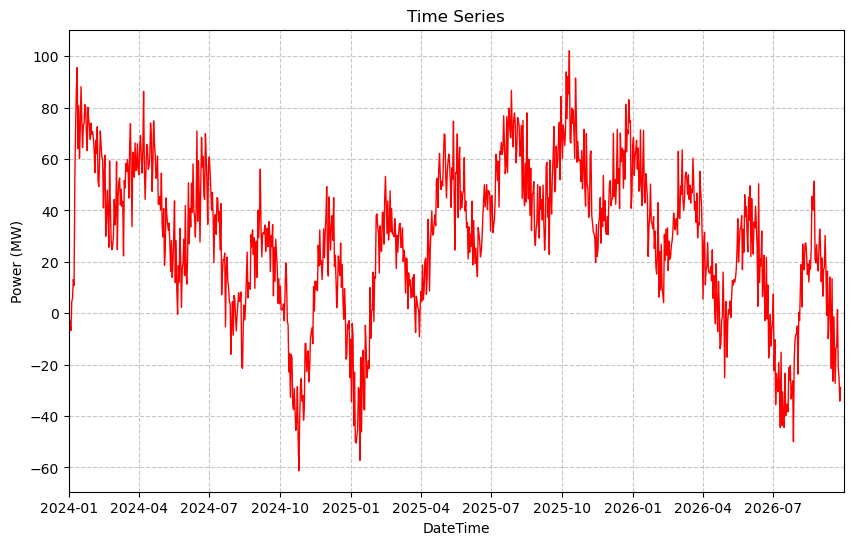

In [20]:
DateTime_init = pd.to_datetime('2024-1-1')
DateTime_step = pd.Timedelta('1d')
Number_step = 1000

##### Generate time indices #####
x_seq = torch.arange(0, Number_step, 1)
DateTime = pd.date_range(start=DateTime_init, periods=Number_step, freq=DateTime_step)

def y_t(x):
    """
    Generates a synthetic time series y(t) using a non-diverging recursive function.

    The function depends on five previous y values (y(t-1) to y(t-5))
    and nine previous x values (x(t) to x(t-8)).

    The formula is:
    y(t) = C1 * tanh(w_y1 * y(t-1) + w_y2 * y(t-2))
         + C2 * sin(w_x1 * x(t) + w_x2 * x(t-1))
         + C3 * sigmoid(w_y3 * y(t-3) + w_x3 * x(t-3))
         + C4 * exp(-abs(y(t-4)))
         + C5 * cos(w_y4 * y(t-5) + w_x4 * x(t-8))

    Args:
        x_sequence (torch.Tensor): A 1D tensor representing the input sequence x(t).
                                   Must have a length of at least 8.

    Returns:
        torch.Tensor: A 1D tensor representing the output sequence y(t).
    """

    torch.manual_seed(21)
    y = torch.randn(x.shape[0], dtype=torch.float32) * 0.1 # Initialize with small random noise

    # --- Coefficients for the non-diverging recursive function ---
    # These coefficients are carefully chosen to ensure complexity without divergence.
    # They balance the influence of past y and x values and different non-linear behaviors.
    C1 = 0.8    # Overall scale for tanh term, influencing recent y values
    w_y1 = 0.5  # Weight for y(t-1) in tanh
    w_y2 = 0.3  # Weight for y(t-2) in tanh

    C2 = 0.7    # Overall scale for sine term, introducing periodicity driven by x
    w_x1 = 0.05 # Weight for x(t) in sine argument
    w_x2 = 0.03 # Weight for x(t-1) in sine argument

    C3 = 0.6    # Overall scale for sigmoid term, providing another bounded non-linearity
    w_y3 = 0.4  # Weight for y(t-3) in sigmoid
    w_x3 = 0.2  # Weight for x(t-3) in sigmoid

    C4 = 0.5    # Overall scale for exponential damping term
                # This term actively pulls y towards 0 if y(t-4) becomes large

    C5 = 0.9    # Overall scale for cosine term, adding more periodicity from distant y and x
    w_y4 = 0.02 # Weight for y(t-5) in cosine argument
    w_x4 = 0.01 # Weight for x(t-8) in cosine argument

    for i in range(8, len(x)):
        # Term 1: C1 * tanh(w_y1 * y(t-1) + w_y2 * y(t-2))
        term1 = C1 * torch.tanh(w_y1 * y[i-1] + w_y2 * y[i-2])

        # Term 2: C2 * sin(w_x1 * x(t) + w_x2 * x(t-1))
        term2 = C2 * torch.sin(w_x1 * x[i] + w_x2 * x[i-1])

        # Term 3: C3 * sigmoid(w_y3 * y(t-3) + w_x3 * x(t-3))
        term3 = C3 * torch.sigmoid(w_y3 * y[i-3] + w_x3 * x[i-3])

        # Term 4: C4 * exp(-abs(y(t-4))) - The damping term
        term4 = C4 * torch.exp(-torch.abs(y[i-4]))

        # Term 5: C5 * cos(w_y4 * y(t-5) + w_x4 * x(t-8))
        term5 = C5 * torch.cos(w_y4 * y[i-5] + w_x4 * x[i-8])

        # Sum all terms to get the current y(t) value
        y_current = term1 + term2 + term3 + term4 + term5
        y[i] = y_current

    return y

y_noiseless = 25 * y_t(x_seq)
y = y_noiseless + 10 * torch.randn(y_noiseless.shape)

scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).flatten()

df = pd.DataFrame({'DateTime': DateTime, 'Power': y.numpy(), 'Power_scaled': y_scaled}, index=DateTime)

loss_dict = {}

##### Visualize y ######

fig1 = plt.figure(figsize=(10, 6))
plt.plot(DateTime, y.numpy(), label='y', color='red', linewidth=1)
plt.title('Time Series')
plt.xlabel('DateTime')
plt.ylabel('Power (MW)')
plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2026-09-30'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [21]:
import plotly.graph_objects as go

fig = go.Figure()

# Plot noisy y(t)
fig.add_trace(go.Scatter(
    x=DateTime,
    y=y.numpy(),
    mode='lines',
    name='y',
    line=dict(color='red', width=1)
))

# Plot noiseless y(t)
fig.add_trace(go.Scatter(
    x=DateTime,
    y=y_noiseless.numpy(),
    mode='lines',
    name='y (noiseless)',
    line=dict(color='blue', width=1.5)
))


# Update layout for title, axis labels, and grid
fig.update_layout(
    title='Time Series Plot',
    xaxis_title='DateTime',
    yaxis_title='Power (MW)',
    hovermode='x unified', # This is useful for time series to see values across traces at a given x
    template='plotly_white' # A clean white background template
)

# Add gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

In [22]:
def to_sequences_timestep(lag, df, y_col='sn_value'):
    """
    Create sliding window sequences and 1-step ahead targets.
    
    Args:
        lag (int): Number of time steps in the input sequence.
        df (pd.DataFrame): DataFrame with time series column.
        y_col (str): Column name for the target series.
    
    Returns:
        x_seq: (N, lag, 1) tensor
        y: (N, 1) tensor (1-step ahead target)
    """
    values = df[y_col].values
    x_seq = []
    y = []

    for i in range(len(values) - lag):
        x_values = values[i:i+lag]
        x_seq.append(x_values)
        y.append(values[i+lag])
        
    x_seq = np.array(x_seq)
    y = np.array(y)

    x_seq = torch.tensor(x_seq, dtype=torch.float32).view(-1, lag, 1)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    return x_seq, y

def train_val_test_seq_split(x_seq, y, datetime, train_size=0.8, val_size=0.1):
    """
    Split sequences into train, validation, and test sets.
    
    Args:
        x_seq (torch.Tensor): Input sequences of shape (N, lag, 1).
        y (torch.Tensor): Target values of shape (N, 1).
        train_size (float): Proportion of data for training.
        val_size (float): Proportion of data for validation.
    
    Returns:
        x_train, y_train: Training set
        x_val, y_val: Validation set
        x_test, y_test: Test set
    """
    n = len(x_seq)
    train_end = int(train_size * n)
    val_end = int((train_size + val_size) * n)

    x_train = x_seq[:train_end]
    y_train = y[:train_end]
    datetime_train = datetime[:train_end]

    x_val = x_seq[train_end:val_end]
    y_val = y[train_end:val_end]
    datetime_val = datetime[train_end:val_end]

    x_test = x_seq[val_end:]
    y_test = y[val_end:]
    datetime_test = datetime[val_end:]

    return x_train, y_train, x_val, y_val, x_test, y_test, datetime_train, datetime_val, datetime_test

### LSTM

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.1, output_size=1, batch_first=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=batch_first
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        out = self.fc(lstm_out[:, -1, :])  # Use the last time step
        return out

### Transformer

In [24]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)       # size: (max_len, 1)
        div_term = 1/10000 ** (torch.arange(0, d_model, 2).float() / d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=16, nhead=4, num_layers=2, dim_feedforward=64, dropout=0.1, output_size=1):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])  # Use the last time step
        return x

## Part 1: Time Lag = $10$

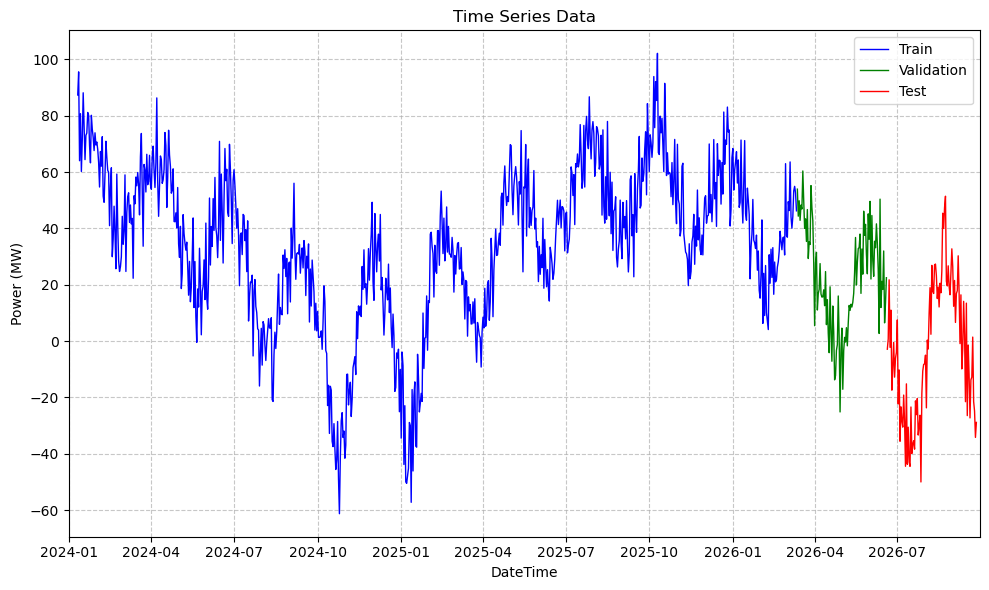

In [65]:
##### Make Input Sequences #####
lag_1 = 10

# Create sequences
x_scaled, y_scaled = to_sequences_timestep(lag_1, df, y_col='Power_scaled')
y_noiseless_plot = y_noiseless[lag_1:]  # Adjust y_true_plot to match the length of y_scaled

# Adjust DateTime to match y_scaled length (since lag reduces total samples)
datetime_seq = df.index[lag_1:]

# Train, validation, and test split
x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, x_test_scaled, y_test_scaled, datetime_train, datetime_val, datetime_test = train_val_test_seq_split(x_scaled, y_scaled, datetime_seq, train_size=0.8, val_size=0.1)

# Make DataLoaders
train_dataset = TensorDataset(x_train_scaled, y_train_scaled)
val_dataset   = TensorDataset(x_val_scaled, y_val_scaled)
test_dataset  = TensorDataset(x_test_scaled, y_test_scaled)
dataset = TensorDataset(x_scaled, y_scaled)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

#### Visualize the train-val-test split ####
fig2 = plt.figure(figsize=(10, 6))
plt.plot(datetime_train, df.loc[datetime_train]['Power'], label='Train', color='blue', linewidth=1)
plt.plot(datetime_val, df.loc[datetime_val]['Power'], label='Validation', color='green', linewidth=1)
plt.plot(datetime_test, df.loc[datetime_test]['Power'], label='Test', color='red', linewidth=1)
plt.title('Time Series Data')
plt.xlabel('DateTime')
plt.ylabel('Power (MW)')
plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2026-09-30'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### LSTM

In [26]:
torch.manual_seed(21)
model = LSTM(input_size=1, hidden_size=30, num_layers=2, dropout=0, output_size=1, batch_first=True)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 10        
min_loss = float('inf')

print("\n--- Model ---")
print("Model architecture:")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


--- Model ---
Model architecture:
LSTM(
  (lstm): LSTM(1, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)
Total parameters: 11431


In [27]:
##### Train the model #####
max_epochs = 100
train_losses = []
val_losses = []

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 5        
min_val_loss = float('inf')

#### In each iteration/epoch has training process and validation process (for early stopping) #####

best_model = model.state_dict()  # Initialize best_model
for epoch in range(max_epochs):
    # Train
    model.train()
    train_loss = []
    for batch in train_dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in val_dataloader:
            x_batch, y_batch = batch
            y_batch_pred = model(x_batch)
            loss = criterion(y_batch_pred, y_batch)
            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        best_model = model.state_dict()
        min_val_loss = val_loss
        early_stop_count = 0
        best_model = model.state_dict()
    else:
        early_stop_count += 1

    if early_stop_count >= patience: 
        print('Early Stopping!')
        break
    
    print(f'Epoch {epoch} | Train Loss: {train_loss: .4f} | Val Loss: {val_loss: .4f}')

model_LSTM_1 = model
model_LSTM_1.load_state_dict(best_model)  # Load the best model

Epoch 0 | Train Loss:  0.8796 | Val Loss:  0.4382
Epoch 1 | Train Loss:  0.6971 | Val Loss:  0.3630
Epoch 2 | Train Loss:  0.4074 | Val Loss:  0.1812
Epoch 3 | Train Loss:  0.2649 | Val Loss:  0.1746
Epoch 4 | Train Loss:  0.2390 | Val Loss:  0.1758
Epoch 5 | Train Loss:  0.2182 | Val Loss:  0.1713
Epoch 6 | Train Loss:  0.2034 | Val Loss:  0.1641
Epoch 7 | Train Loss:  0.1926 | Val Loss:  0.1575
Epoch 8 | Train Loss:  0.1842 | Val Loss:  0.1518
Epoch 9 | Train Loss:  0.1780 | Val Loss:  0.1466
Epoch 10 | Train Loss:  0.1730 | Val Loss:  0.1432
Epoch 11 | Train Loss:  0.1696 | Val Loss:  0.1392
Epoch 12 | Train Loss:  0.1663 | Val Loss:  0.1385
Epoch 13 | Train Loss:  0.1645 | Val Loss:  0.1350
Epoch 14 | Train Loss:  0.1618 | Val Loss:  0.1375
Epoch 15 | Train Loss:  0.1615 | Val Loss:  0.1335
Epoch 16 | Train Loss:  0.1587 | Val Loss:  0.1403
Epoch 17 | Train Loss:  0.1605 | Val Loss:  0.1363
Epoch 18 | Train Loss:  0.1573 | Val Loss:  0.1483
Epoch 19 | Train Loss:  0.1622 | Val Loss

<All keys matched successfully>

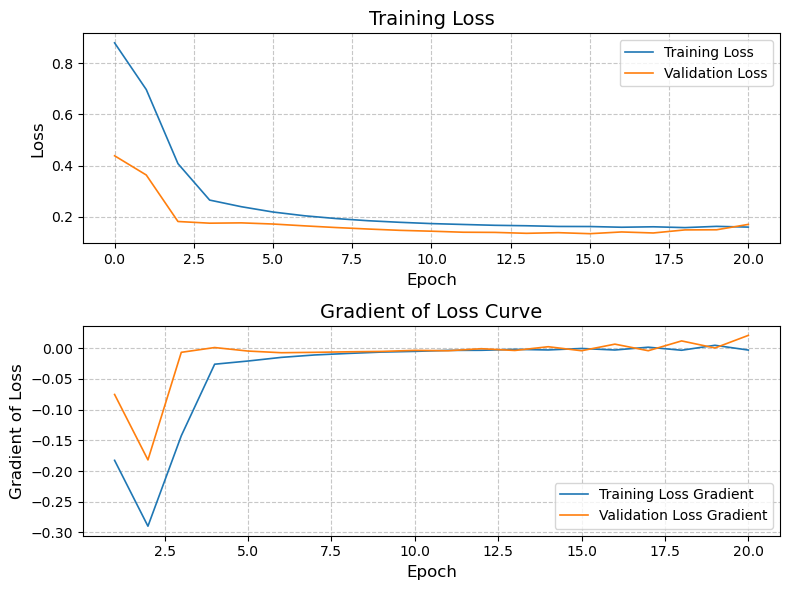

In [28]:
##### Compute Loss Gradient #####

train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)

train_losses_diff = np.diff(train_losses_np)
val_losses_diff = np.diff(val_losses_np)
epochs_diff = np.arange(1, len(train_losses_diff)+1)

##### Plot Loss Curve and Loss Gradient Curve #####

fig3, ax = plt.subplots(2, 1, figsize=(8, 6))

# --- Loss Curve ---
ax[0].plot(train_losses_np, label='Training Loss', linewidth=1.2)
ax[0].plot(val_losses_np, label='Validation Loss', linewidth=1.2)
ax[0].set_title('Training Loss', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

# --- Loss Gradient Curve ---
ax[1].plot(epochs_diff, train_losses_diff, label='Training Loss Gradient',  linewidth=1.2)
ax[1].plot(epochs_diff, val_losses_diff, label='Validation Loss Gradient',  linewidth=1.2)
ax[1].set_title('Gradient of Loss Curve', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Gradient of Loss', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.show()

Test MSE: 161.1737


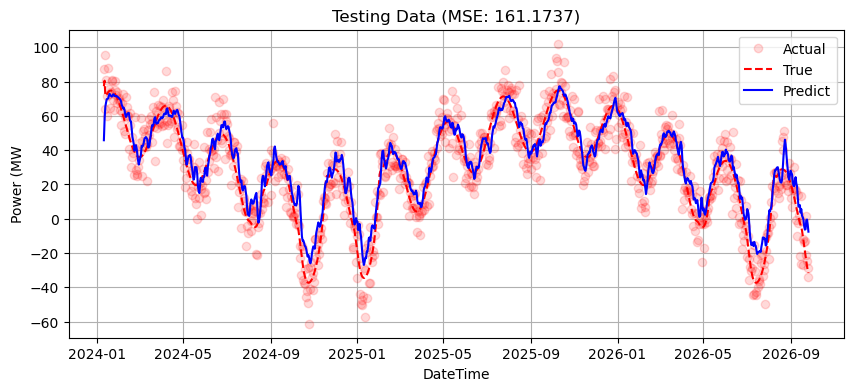

In [70]:
##### Evaluate the model #####
model.eval()

y_true = []
y_preds = []

# Disable gradient calculation to save memory and speed up computations
with torch.no_grad():
    for batch in dataloader:
        x_batch, y_batch = batch
        y_pred = model_LSTM_1(x_batch)
        y_preds.append(y_pred)
        y_true.append(y_batch)

# Concatenate all batches
y_pred_all = torch.cat(y_preds, dim=0)
y_true_all = torch.cat(y_true, dim=0)

y_pred_all = scaler.inverse_transform(y_pred_all.numpy())
y_true_all = scaler.inverse_transform(y_true_all.numpy())

# Compute MSE
mse_test = criterion(torch.tensor(y_pred_all), torch.tensor(y_true_all)).item()
print(f'Test MSE: {mse_test:.4f}')

# Store the results
df['LSTM_1'] = np.nan
df.loc[datetime_seq, 'LSTM_1'] = y_pred_all.flatten()
loss_dict['LSTM_1'] = mse_test

# Plot predictions vs true values
fig4 = plt.figure(figsize=(10, 4))
plt.plot(datetime_seq, y_true_all, 'o', c='red', alpha=0.15, label='Actual')
plt.plot(datetime_seq, y_noiseless_plot, '--', c='red', label='True')
plt.plot(datetime_seq, y_pred_all, c='blue', label='Predict')
plt.xlabel('DateTime')
plt.ylabel('Power (MW')
plt.legend()
plt.grid(True)
plt.title(f'Testing Data (MSE: {mse_test:.4f})')
plt.show()

### Transformer

In [30]:
torch.manual_seed(21)
model = TransformerModel(input_dim=1, d_model = 24, nhead = 2, num_layers = 3, dim_feedforward = 32, dropout = 0, output_size=1)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 10        
min_loss = float('inf')

print("\n--- Model ---")
print("Model architecture:")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


--- Model ---
Model architecture:
TransformerModel(
  (encoder): Linear(in_features=1, out_features=24, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=24, out_features=24, bias=True)
        )
        (linear1): Linear(in_features=24, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=32, out_features=24, bias=True)
        (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=24, out_features=1, bias=True)
)
Total parameters: 12337


In [31]:
##### Train the model #####
max_epochs = 100
train_losses = []
val_losses = []

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 5        
min_val_loss = float('inf')

#### In each iteration/epoch has training process and validation process (for early stopping) #####

best_model = model.state_dict()  # Initialize best_model
for epoch in range(max_epochs):
    # Train
    model.train()
    train_loss = []
    for batch in train_dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in val_dataloader:
            x_batch, y_batch = batch
            y_batch_pred = model(x_batch)
            loss = criterion(y_batch_pred, y_batch)
            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        best_model = model.state_dict()
        min_val_loss = val_loss
        early_stop_count = 0
        best_model = model.state_dict()
    else:
        early_stop_count += 1

    if early_stop_count >= patience: 
        print('Early Stopping!')
        break
    
    print(f'Epoch {epoch} | Train Loss: {train_loss: .4f} | Val Loss: {val_loss: .4f}')

model_Transformer_1 = model
model_Transformer_1.load_state_dict(best_model)  # Load the best model

Epoch 0 | Train Loss:  0.8958 | Val Loss:  0.2227
Epoch 1 | Train Loss:  0.3082 | Val Loss:  0.2229
Epoch 2 | Train Loss:  0.2361 | Val Loss:  0.2082
Epoch 3 | Train Loss:  0.2236 | Val Loss:  0.2122
Epoch 4 | Train Loss:  0.2021 | Val Loss:  0.2003
Epoch 5 | Train Loss:  0.1946 | Val Loss:  0.2149
Epoch 6 | Train Loss:  0.1893 | Val Loss:  0.2275
Epoch 7 | Train Loss:  0.1879 | Val Loss:  0.2395
Epoch 8 | Train Loss:  0.1869 | Val Loss:  0.2542
Early Stopping!


<All keys matched successfully>

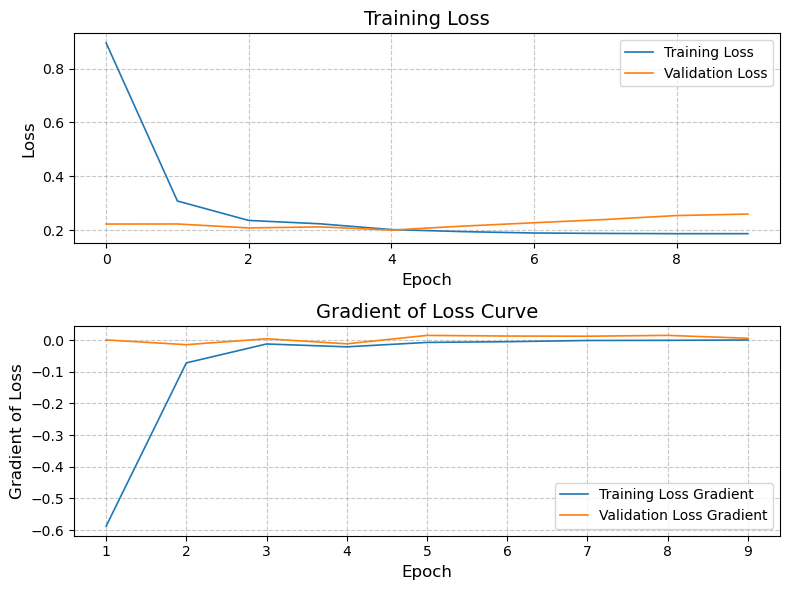

In [32]:
##### Compute Loss Gradient #####

train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)

train_losses_diff = np.diff(train_losses_np)
val_losses_diff = np.diff(val_losses_np)
epochs_diff = np.arange(1, len(train_losses_diff)+1)

##### Plot Loss Curve and Loss Gradient Curve #####

fig5, ax = plt.subplots(2, 1, figsize=(8, 6))

# --- Loss Curve ---
ax[0].plot(train_losses_np, label='Training Loss', linewidth=1.2)
ax[0].plot(val_losses_np, label='Validation Loss', linewidth=1.2)
ax[0].set_title('Training Loss', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

# --- Loss Gradient Curve ---
ax[1].plot(epochs_diff, train_losses_diff, label='Training Loss Gradient',  linewidth=1.2)
ax[1].plot(epochs_diff, val_losses_diff, label='Validation Loss Gradient',  linewidth=1.2)
ax[1].set_title('Gradient of Loss Curve', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Gradient of Loss', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.show()

Test MSE: 173.1489


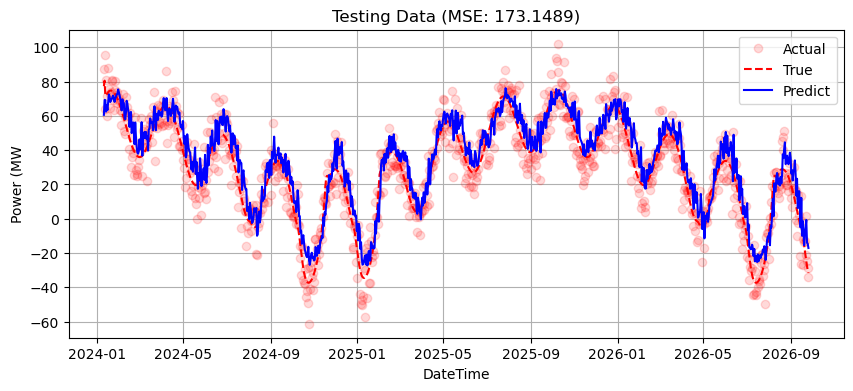

In [71]:
##### Evaluate the model #####
model.eval()

y_true = []
y_preds = []

# Disable gradient calculation to save memory and speed up computations
with torch.no_grad():
    for batch in dataloader:
        x_batch, y_batch = batch
        y_pred = model_Transformer_1(x_batch)
        y_preds.append(y_pred)
        y_true.append(y_batch)

# Concatenate all batches
y_pred_all = torch.cat(y_preds, dim=0)
y_true_all = torch.cat(y_true, dim=0)

y_pred_all = scaler.inverse_transform(y_pred_all.numpy())
y_true_all = scaler.inverse_transform(y_true_all.numpy())

# Compute MSE
mse_test = criterion(torch.tensor(y_pred_all), torch.tensor(y_true_all)).item()
print(f'Test MSE: {mse_test:.4f}')

# Store the results
df['Transformer_1'] = np.nan
df.loc[datetime_seq, 'Transformer_1'] = y_pred_all.flatten()
loss_dict['Transformer_1'] = mse_test

# Plot predictions vs true values
fig6 = plt.figure(figsize=(10, 4))
plt.plot(datetime_seq, y_true_all, 'o', c='red', alpha=0.15, label='Actual')
plt.plot(datetime_seq, y_noiseless_plot, '--', c='red', label='True')
plt.plot(datetime_seq, y_pred_all, c='blue', label='Predict')
plt.xlabel('DateTime')
plt.ylabel('Power (MW')
plt.legend()
plt.grid(True)
plt.title(f'Testing Data (MSE: {mse_test:.4f})')
plt.show()

## Part 2: Time Lag = $100$

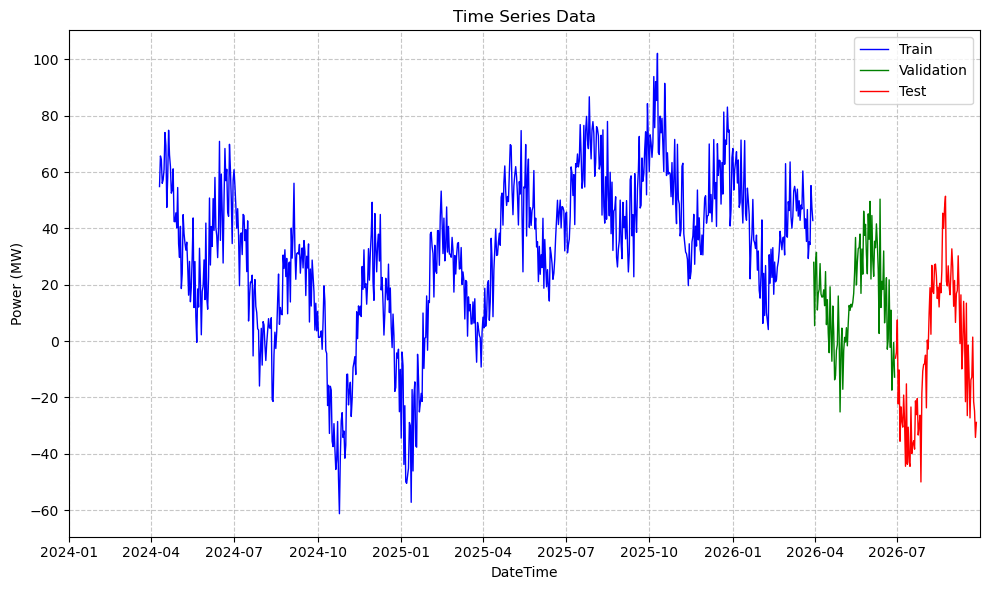

In [72]:
##### Make Input Sequences #####
lag_2 = 100

# Create sequences
x_scaled, y_scaled = to_sequences_timestep(lag_2, df, y_col='Power_scaled')
y_noiseless_plot = y_noiseless[lag_2:]  # Adjust y_true_plot to match the length of y_scaled

# Adjust DateTime to match y_scaled length (since lag reduces total samples)
datetime_seq = df.index[lag_2:]

# Train, validation, and test split
x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled, x_test_scaled, y_test_scaled, datetime_train, datetime_val, datetime_test = train_val_test_seq_split(x_scaled, y_scaled, datetime_seq, train_size=0.8, val_size=0.1)

# Make DataLoaders
train_dataset = TensorDataset(x_train_scaled, y_train_scaled)
val_dataset   = TensorDataset(x_val_scaled, y_val_scaled)
test_dataset  = TensorDataset(x_test_scaled, y_test_scaled)
dataset = TensorDataset(x_scaled, y_scaled)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_dataloader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

#### Visualize the train-val-test split ####
fig7 = plt.figure(figsize=(10, 6))
plt.plot(datetime_train, df.loc[datetime_train]['Power'], label='Train', color='blue', linewidth=1)
plt.plot(datetime_val, df.loc[datetime_val]['Power'], label='Validation', color='green', linewidth=1)
plt.plot(datetime_test, df.loc[datetime_test]['Power'], label='Test', color='red', linewidth=1)
plt.title('Time Series Data')
plt.xlabel('DateTime')
plt.ylabel('Power (MW)')
plt.xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2026-09-30'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### LSTM

In [35]:
torch.manual_seed(21)
model = LSTM(input_size=1, hidden_size=30, num_layers=2, dropout=0, output_size=1, batch_first=True)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 10        
min_loss = float('inf')

print("\n--- Model ---")
print("Model architecture:")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


--- Model ---
Model architecture:
LSTM(
  (lstm): LSTM(1, 30, num_layers=2, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)
Total parameters: 11431


In [36]:
##### Train the model #####
max_epochs = 100
train_losses = []
val_losses = []

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 5        
min_val_loss = float('inf')

#### In each iteration/epoch has training process and validation process (for early stopping) #####

best_model = model.state_dict()  # Initialize best_model
for epoch in range(max_epochs):
    # Train
    model.train()
    train_loss = []
    for batch in train_dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in val_dataloader:
            x_batch, y_batch = batch
            y_batch_pred = model(x_batch)
            loss = criterion(y_batch_pred, y_batch)
            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        best_model = model.state_dict()
        min_val_loss = val_loss
        early_stop_count = 0
        best_model = model.state_dict()
    else:
        early_stop_count += 1

    if early_stop_count >= patience: 
        print('Early Stopping!')
        break
    
    print(f'Epoch {epoch} | Train Loss: {train_loss: .4f} | Val Loss: {val_loss: .4f}')

model_LSTM_2 = model
model_LSTM_2.load_state_dict(best_model)  # Load the best model

Epoch 0 | Train Loss:  0.8422 | Val Loss:  0.5300
Epoch 1 | Train Loss:  0.6658 | Val Loss:  0.4224
Epoch 2 | Train Loss:  0.3888 | Val Loss:  0.3019
Epoch 3 | Train Loss:  0.2737 | Val Loss:  0.2343
Epoch 4 | Train Loss:  0.2323 | Val Loss:  0.2163
Epoch 5 | Train Loss:  0.2072 | Val Loss:  0.1986
Epoch 6 | Train Loss:  0.1911 | Val Loss:  0.1841
Epoch 7 | Train Loss:  0.1779 | Val Loss:  0.1751
Epoch 8 | Train Loss:  0.1697 | Val Loss:  0.1629
Epoch 9 | Train Loss:  0.1608 | Val Loss:  0.1618
Epoch 10 | Train Loss:  0.1587 | Val Loss:  0.1550
Epoch 11 | Train Loss:  0.1523 | Val Loss:  0.1662
Epoch 12 | Train Loss:  0.1596 | Val Loss:  0.1897
Epoch 13 | Train Loss:  0.1580 | Val Loss:  0.2126
Epoch 14 | Train Loss:  0.1815 | Val Loss:  0.2580
Early Stopping!


<All keys matched successfully>

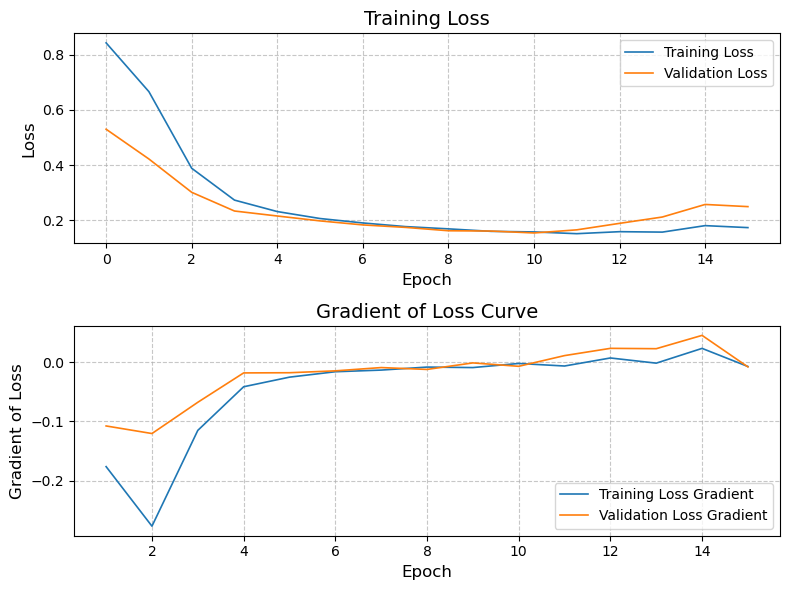

In [37]:
##### Compute Loss Gradient #####

train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)

train_losses_diff = np.diff(train_losses_np)
val_losses_diff = np.diff(val_losses_np)
epochs_diff = np.arange(1, len(train_losses_diff)+1)

##### Plot Loss Curve and Loss Gradient Curve #####

fig8, ax = plt.subplots(2, 1, figsize=(8, 6))

# --- Loss Curve ---
ax[0].plot(train_losses_np, label='Training Loss', linewidth=1.2)
ax[0].plot(val_losses_np, label='Validation Loss', linewidth=1.2)
ax[0].set_title('Training Loss', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

# --- Loss Gradient Curve ---
ax[1].plot(epochs_diff, train_losses_diff, label='Training Loss Gradient',  linewidth=1.2)
ax[1].plot(epochs_diff, val_losses_diff, label='Validation Loss Gradient',  linewidth=1.2)
ax[1].set_title('Gradient of Loss Curve', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Gradient of Loss', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.show()

Test MSE: 200.7208


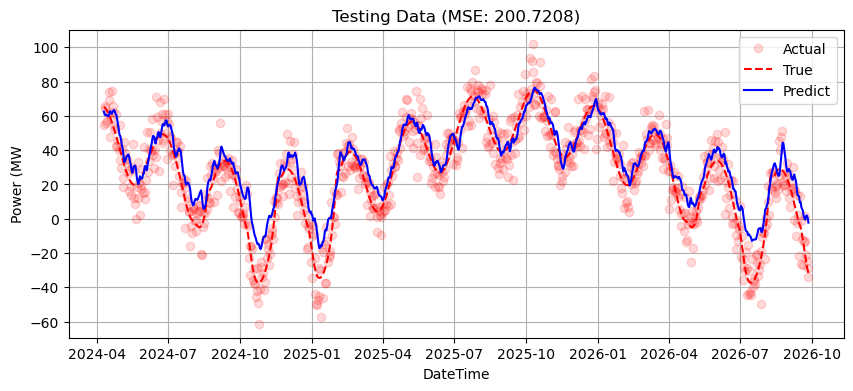

In [74]:
##### Evaluate the model #####
model.eval()

y_true = []
y_preds = []

# Disable gradient calculation to save memory and speed up computations
with torch.no_grad():
    for batch in dataloader:
        x_batch, y_batch = batch
        y_pred = model_LSTM_2(x_batch)
        y_preds.append(y_pred)
        y_true.append(y_batch)

# Concatenate all batches
y_pred_all = torch.cat(y_preds, dim=0)
y_true_all = torch.cat(y_true, dim=0)

y_pred_all = scaler.inverse_transform(y_pred_all.numpy())
y_true_all = scaler.inverse_transform(y_true_all.numpy())

# Compute MSE
mse_test = criterion(torch.tensor(y_pred_all), torch.tensor(y_true_all)).item()
print(f'Test MSE: {mse_test:.4f}')

# Store the results
df['LSTM_2'] = np.nan
df.loc[datetime_seq, 'LSTM_2'] = y_pred_all.flatten()
loss_dict['LSTM_2'] = mse_test

# Plot predictions vs true values
fig9 = plt.figure(figsize=(10, 4))
plt.plot(datetime_seq, y_true_all, 'o', c='red', alpha=0.15, label='Actual')
plt.plot(datetime_seq, y_noiseless_plot, '--', c='red', label='True')
plt.plot(datetime_seq, y_pred_all, c='blue', label='Predict')
plt.xlabel('DateTime')
plt.ylabel('Power (MW')
plt.legend()
plt.grid(True)
plt.title(f'Testing Data (MSE: {mse_test:.4f})')
plt.show()

### Transformer

In [39]:
torch.manual_seed(21)
model = TransformerModel(input_dim=1, d_model = 24, nhead = 2, num_layers = 3, dim_feedforward = 32, dropout = 0, output_size=1)
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 10        
min_loss = float('inf')

print("\n--- Model ---")
print("Model architecture:")
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


--- Model ---
Model architecture:
TransformerModel(
  (encoder): Linear(in_features=1, out_features=24, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=24, out_features=24, bias=True)
        )
        (linear1): Linear(in_features=24, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=32, out_features=24, bias=True)
        (norm1): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((24,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=24, out_features=1, bias=True)
)
Total parameters: 12337


In [40]:
##### Train the model #####
max_epochs = 100
train_losses = []
val_losses = []

#### Adding an Early stopping and Scheduler into the training process #####
early_stop_count = 0    
patience = 5        
min_val_loss = float('inf')

#### In each iteration/epoch has training process and validation process (for early stopping) #####

best_model = model.state_dict()  # Initialize best_model
for epoch in range(max_epochs):
    # Train
    model.train()
    train_loss = []
    for batch in train_dataloader:
        x_batch, y_batch = batch
        optimizer.zero_grad()
        y_batch_pred = model(x_batch)
        loss = criterion(y_batch_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = []
    with torch.no_grad():
        for batch in val_dataloader:
            x_batch, y_batch = batch
            y_batch_pred = model(x_batch)
            loss = criterion(y_batch_pred, y_batch)
            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)
    val_losses.append(val_loss)

    if val_loss < min_val_loss:
        best_model = model.state_dict()
        min_val_loss = val_loss
        early_stop_count = 0
        best_model = model.state_dict()
    else:
        early_stop_count += 1

    if early_stop_count >= patience: 
        print('Early Stopping!')
        break
    
    print(f'Epoch {epoch} | Train Loss: {train_loss: .4f} | Val Loss: {val_loss: .4f}')

model_Transformer_2 = model
model_Transformer_2.load_state_dict(best_model)  # Load the best model

Epoch 0 | Train Loss:  1.1614 | Val Loss:  0.3872
Epoch 1 | Train Loss:  0.4199 | Val Loss:  0.3056
Epoch 2 | Train Loss:  0.3099 | Val Loss:  0.3287
Epoch 3 | Train Loss:  0.2770 | Val Loss:  0.2833
Epoch 4 | Train Loss:  0.2313 | Val Loss:  0.2872
Epoch 5 | Train Loss:  0.2301 | Val Loss:  0.3208
Epoch 6 | Train Loss:  0.2314 | Val Loss:  0.3123
Epoch 7 | Train Loss:  0.2152 | Val Loss:  0.2965
Early Stopping!


<All keys matched successfully>

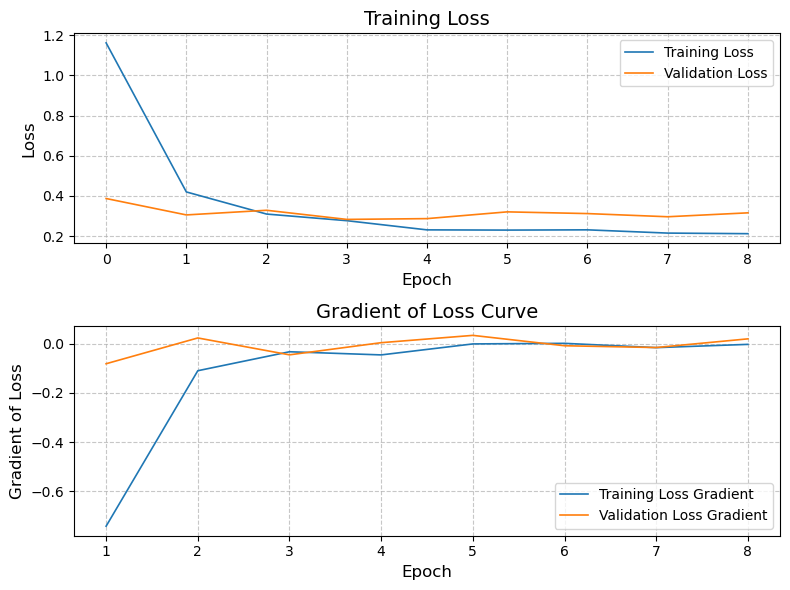

In [41]:
##### Compute Loss Gradient #####

train_losses_np = np.array(train_losses)
val_losses_np = np.array(val_losses)

train_losses_diff = np.diff(train_losses_np)
val_losses_diff = np.diff(val_losses_np)
epochs_diff = np.arange(1, len(train_losses_diff)+1)

##### Plot Loss Curve and Loss Gradient Curve #####

fig10, ax = plt.subplots(2, 1, figsize=(8, 6))

# --- Loss Curve ---
ax[0].plot(train_losses_np, label='Training Loss', linewidth=1.2)
ax[0].plot(val_losses_np, label='Validation Loss', linewidth=1.2)
ax[0].set_title('Training Loss', fontsize=14)
ax[0].set_xlabel('Epoch', fontsize=12)
ax[0].set_ylabel('Loss', fontsize=12)
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].legend()

# --- Loss Gradient Curve ---
ax[1].plot(epochs_diff, train_losses_diff, label='Training Loss Gradient',  linewidth=1.2)
ax[1].plot(epochs_diff, val_losses_diff, label='Validation Loss Gradient',  linewidth=1.2)
ax[1].set_title('Gradient of Loss Curve', fontsize=14)
ax[1].set_xlabel('Epoch', fontsize=12)
ax[1].set_ylabel('Gradient of Loss', fontsize=12)
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.show()

Test MSE: 198.3732


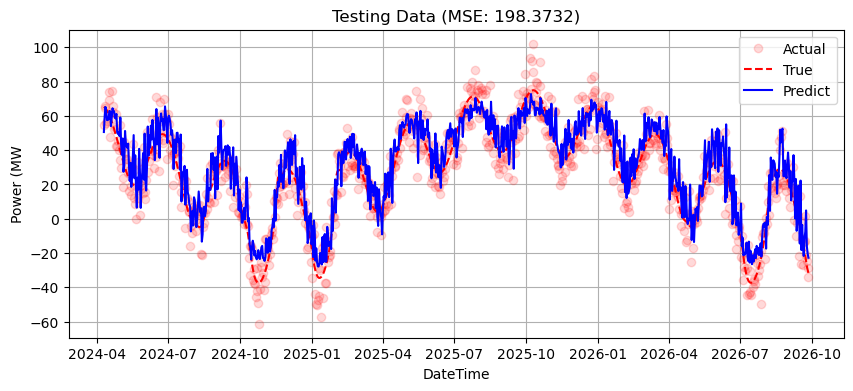

In [73]:
##### Evaluate the model #####
model.eval()

y_true = []
y_preds = []

# Disable gradient calculation to save memory and speed up computations
with torch.no_grad():
    for batch in dataloader:
        x_batch, y_batch = batch
        y_pred = model_Transformer_2(x_batch)
        y_preds.append(y_pred)
        y_true.append(y_batch)

# Concatenate all batches
y_pred_all = torch.cat(y_preds, dim=0)
y_true_all = torch.cat(y_true, dim=0)

y_pred_all = scaler.inverse_transform(y_pred_all.numpy())
y_true_all = scaler.inverse_transform(y_true_all.numpy())

# Compute MSE
mse_test = criterion(torch.tensor(y_pred_all), torch.tensor(y_true_all)).item()
print(f'Test MSE: {mse_test:.4f}')

# Store the results
df['Transformer_2'] = np.nan
df.loc[datetime_seq, 'Transformer_2'] = y_pred_all.flatten()
loss_dict['Transformer_2'] = mse_test

# Plot predictions vs true values
fig11 = plt.figure(figsize=(10, 4))
plt.plot(datetime_seq, y_true_all, 'o', c='red', alpha=0.15, label='Actual')
plt.plot(datetime_seq, y_noiseless_plot, '--', c='red', label='True')
plt.plot(datetime_seq, y_pred_all, c='blue', label='Predict')
plt.xlabel('DateTime')
plt.ylabel('Power (MW')
plt.legend()
plt.grid(True)
plt.title(f'Testing Data (MSE: {mse_test:.4f})')
plt.show()

## Compare Results

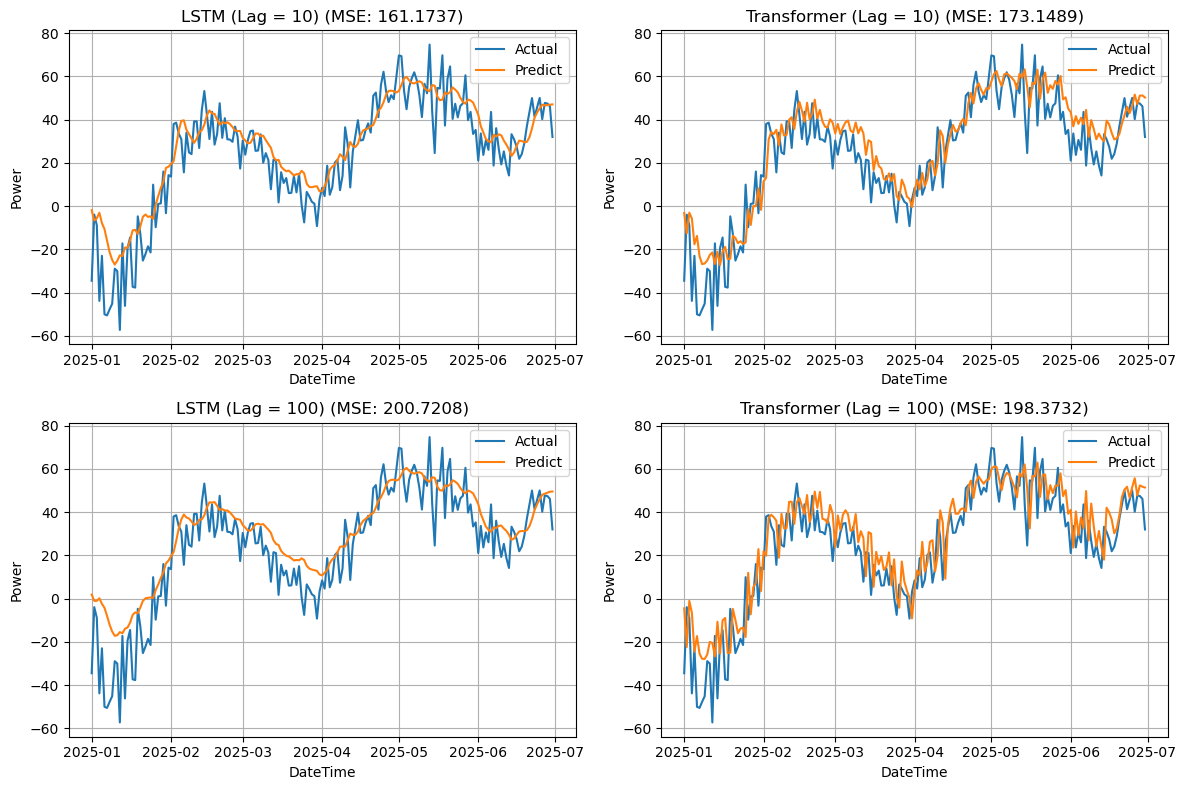

In [78]:
# Filter df_test within the date range
start_date = pd.to_datetime("2025-1-1")
end_date = pd.to_datetime("2025-6-30")

mask = df.index.to_series().between(start_date, end_date)
df_plot = df.loc[mask]

# df_plot = df.copy()

# Make a subplot figure
fig12, ax = plt.subplots(2, 2, figsize=(12, 8))

mask_cols = ['LSTM_1', 'Transformer_1', 'LSTM_2', 'Transformer_2']
col_names = ['LSTM (Lag = 10)', 'Transformer (Lag = 10)', 'LSTM (Lag = 100)', 'Transformer (Lag = 100)']

for i in range(2*2):
    j = i // 2
    k = i % 2
    
    ax[j, k].plot(df_plot.index, df_plot['Power'], label='Actual')
    ax[j, k].plot(df_plot.index, df_plot[mask_cols[i]], label='Predict')
    ax[j, k].set_title(f'{col_names[i]} (MSE: {loss_dict[mask_cols[i]]:.4f})')
    ax[j, k].set_xlabel('DateTime')
    ax[j, k].set_ylabel('Power')
    ax[j, k].legend()
    ax[j, k].grid()

plt.tight_layout()
plt.show()

In [79]:
# fig1.savefig('advanced_dataset_fig1.pdf', bbox_inches='tight')
# fig2.savefig('advanced_dataset_fig2.pdf', bbox_inches='tight')
# fig3.savefig('advanced_dataset_fig3.pdf', bbox_inches='tight')
# fig4.savefig('advanced_dataset_fig4.pdf', bbox_inches='tight')
# fig5.savefig('advanced_dataset_fig5.pdf', bbox_inches='tight')
# fig6.savefig('advanced_dataset_fig6.pdf', bbox_inches='tight')
# fig7.savefig('advanced_dataset_fig7.pdf', bbox_inches='tight')
# fig8.savefig('advanced_dataset_fig8.pdf', bbox_inches='tight')
# fig9.savefig('advanced_dataset_fig9.pdf', bbox_inches='tight')
# fig10.savefig('advanced_dataset_fig10.pdf', bbox_inches='tight')
# fig11.savefig('advanced_dataset_fig11.pdf', bbox_inches='tight')
fig12.savefig('advanced_dataset_fig12.pdf', bbox_inches='tight')